<a href="https://colab.research.google.com/github/axellee1994/Dog_Vision_CV/blob/main/Dog_Vision_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification

This notebook build an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1.Problem

Identifying the breed of a dog given an image of a dog.

## 2.Data

The data used is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/overview

## 3.Evaluation

Evaluation is a file with prediction probabilitirs for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview

## 4.Features

Some information about the data:
* Dealing with images (unstructred data) so it's best to use deep learning/transfer learning
* 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set (These have labels)
* There are around 10,000+ images in the test set (These have no labels, because we will want to predict them)


## Getting workspace ready
* Import TensorFlow 2.X
* Import TensorFlow Hub
* Make sure this is using a GPU

In [5]:
# Unzip the uploaded data into Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

!unzip "drive/MyDrive/Dog_Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog_Vision"

unzip:  cannot find or open drive/MyDrive/Dog_Vision/dog-breed-identification.zip, drive/MyDrive/Dog_Vision/dog-breed-identification.zip.zip or drive/MyDrive/Dog_Vision/dog-breed-identification.zip.ZIP.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.19.0
Hub version: 0.16.1


In [8]:
# # If Tensorflow is under 2.X
# try:
#   # %tensorflow_version only exists in Colab
#   %tensorflow_version 2.x
# except Exception:
#     pass
# print ("TensorFlow Version: ", tf.__version__)

In [9]:
# Check for GPU availability
# Click Runtime -> Change runtime type -> Select GPU

physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:",physical_devices)
print("Number of GPU:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPU: 1


# Preparing The Images

Getting our data ready (Turning into Tensors)

With all machine learning models, out data has to be in numerical format.
Turning our images into Tensors(numerical differences)

In [10]:
# Checkout labels of our data

import pandas as pd

labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head(5))

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

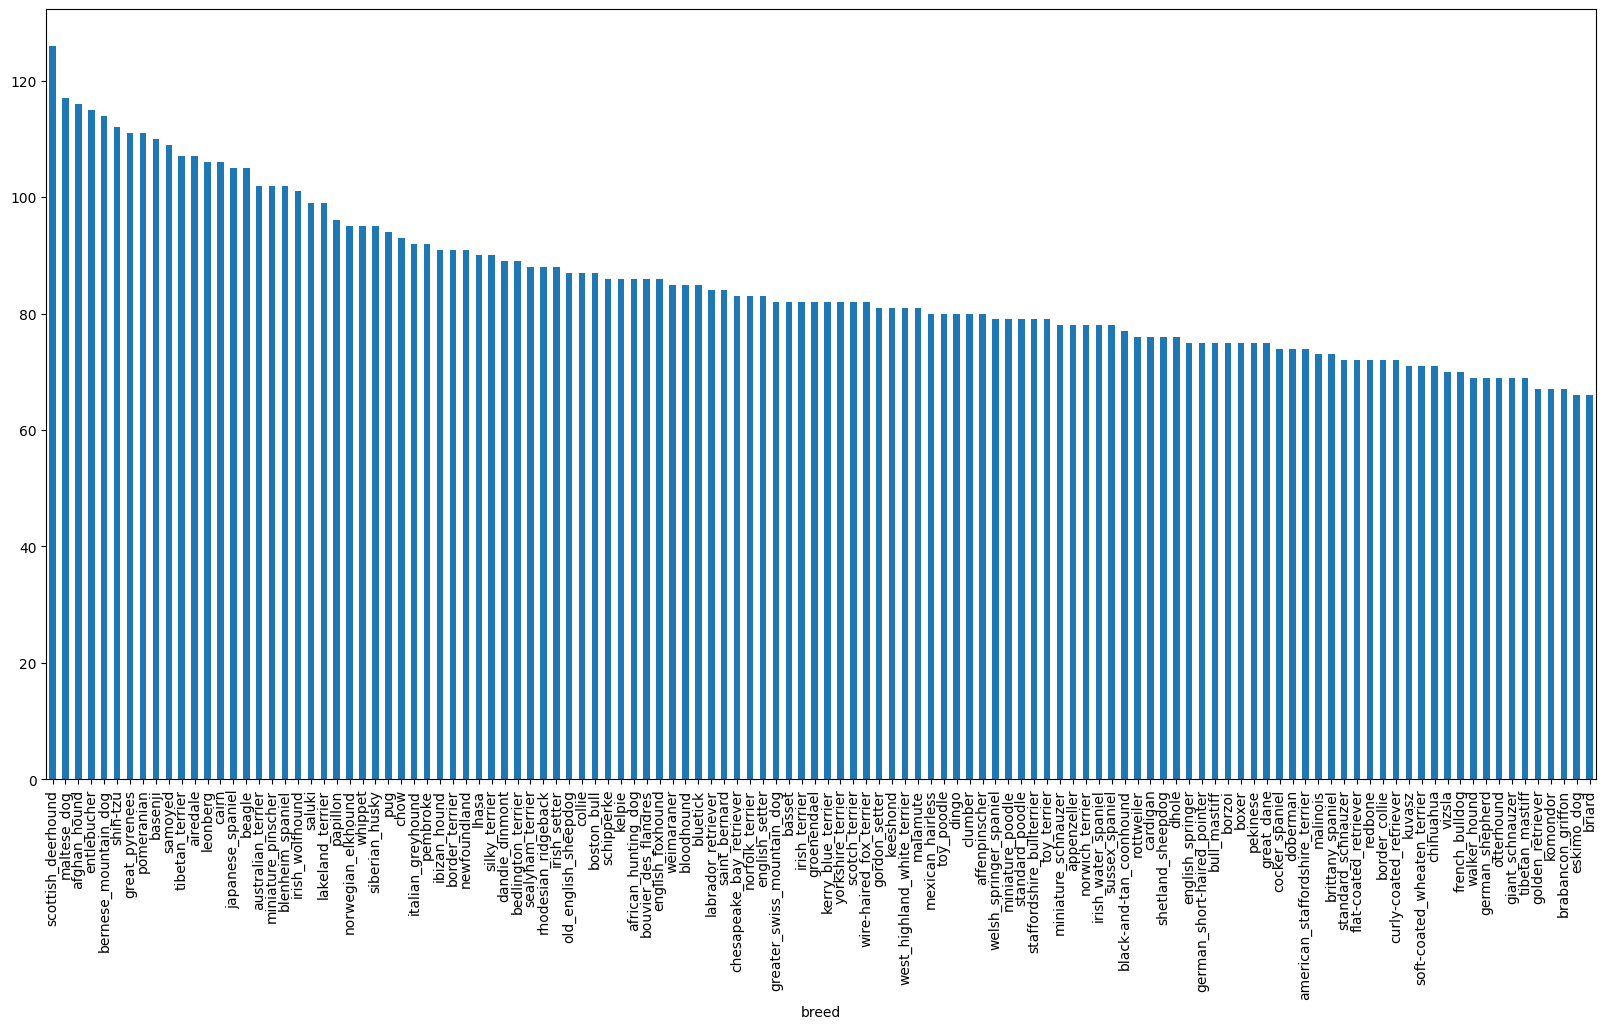

In [11]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [9]:
# Average number of photos in the training set
labels_csv["breed"].value_counts().median()

82.0

In [10]:
# Google recommends about 1000 training images per label.
# Minimum is about 10 per label

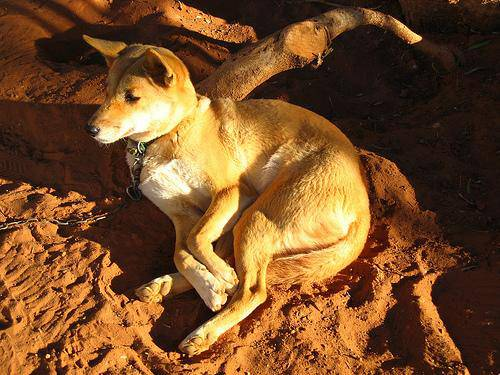

In [12]:
# Viewing an image

from IPython.display import Image
Image("drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

. A list of all of the image file pathnames

In [14]:
#Create pathnames from Image ID's

base_path = "drive/MyDrive/Dog_Vision/train/"

image_id = []
for i in labels_csv["id"]:
  image_id.append(i)

file_extension = ".jpg"

filenames = []
for i in range(len(labels_csv)):
  filenames.append(f"{base_path}{image_id[i]}{file_extension}")

# Another way of doing it -> filenames = ["drive/MyDrive/Dog_Vision/train" + fname + ".jpg" for fname in labels_csv[id]]

# Check number of filenames is the same as the number of files in the folder train
import os

if len(os.listdir("drive/MyDrive/Dog_Vision/train/")) == len(filenames):
  print("Same length")
else:
  print("Different length")

Same length


In [15]:
# Check that one image is printed correctly

Image(filenames[0])
print(labels_csv["breed"][0])

boston_bull


Since we have now gotten the training image filepaths in a list. time to prepare for the labels

In [16]:
import numpy as np

# Another method labels = labels_csv["breed"].to_numpy()
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [17]:
# Check for missing data
# In unstructured data, harder to check for missing data -> use len(labels) to match the amount of filenames to see for missing data

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")


Number of labels matches number of filenames


In [18]:
# Find the unique label values

unique_breeds = np.unique(labels)
print(unique_breeds)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [25]:
# Turn every label into a boolean array

boolean_labels = [label == np.array(unique_breeds) for label in labels]
print(boolean_labels[:2])

[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]), array([False, False, False, False, False, False, False, Fal

In [26]:
print(len(boolean_labels))

10222


In [27]:
# Example: Turning boolean array into integers

print(labels[0])
print(np.where(unique_breeds == labels[0])) #Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating out own validation set

Since the dataset from Kaggle doesn't come with a validation set, I will be creating on my own

In [28]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [29]:
len(filenames)

10222

Test on a small sample size first (1000) before increasing as I needed


In [30]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [31]:
# Create training and validation set
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size of NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [32]:
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog_Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog_Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog_Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog_Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog_Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing images into tensors

**`Things to do`**:
> 1. Take a `Image` filename as input.
2. Use TensorFlow to read the file and save it to a variable.
3. Turn the `Image` into Tensor.
4. Normalize color channel(turn the value from 0-225, to 0-1)
5. Resize the `Image` to shape (224, 224)
6. Return the modified `Image`

In [34]:
from matplotlib.pyplot import imread
image = imread(filenames[42]) # Reading an image
image.shape # Height, Width, Color Channel

(257, 350, 3)

In [38]:
# Custom Function to process images
# 224 is the standard, good computation efficienc
IMAGE_SIZE = 224

def get_image(filepath, image_size=IMAGE_SIZE):
  # Read the filepath
  image = tf.io.read_file(filepath)

  # Split it into 3 channels
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert them from 255 RGB values to [0,1]
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize them to 224
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

  return image
get_image(filenames[2])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3918853 , 0.3918853 , 0.36051273],
        [0.43775532, 0.43775532, 0.40638277],
        [0.44351017, 0.44351017, 0.41213763],
        ...,
        [0.05796662, 0.02239764, 0.01937653],
        [0.05252095, 0.0470589 , 0.04978992],
        [0.04586835, 0.05371149, 0.04978992]],

       [[0.38653433, 0.38261276, 0.3630049 ],
        [0.4161569 , 0.41223532, 0.39262748],
        [0.43315482, 0.42923325, 0.4096254 ],
        ...,
        [0.0909924 , 0.05177672, 0.04754004],
        [0.03035708, 0.02489503, 0.02762605],
        [0.02370449, 0.03154762, 0.02762605]],

       [[0.36859885, 0.36467728, 0.34506944],
        [0.35422263, 0.35030106, 0.33069322],
        [0.39899355, 0.39507198, 0.3754641 ],
        ...,
        [0.2361781 , 0.20233706, 0.19541305],
        [0.04896353, 0.04268564, 0.04582458],
        [0.04459034, 0.04705883, 0.04582458]],

       ...,

       [[0.7591447 , 0.75522316, 0.7356153 ],
        [0.74

TensorFlow needs to use Tensor tuples, will need to create a function to return tuples.

In [39]:
def get_image_label(filepath, label):
  image = get_image(filepath)
  return image, label

In [40]:
# Testing out function
get_image_label(filenames[42], boolean_labels[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Since there is now a way to turn data into tuples of tensors in the form of "(image, label)", need to create a function to turn all of data (X & y) into batches

In [41]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(get_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [42]:
# Create training and validation data batches
train_dataset = create_data_batches(X_train, y_train)
val_dataset = create_data_batches(X_val, y_val)

Creating training data batches...
Creating training data batches...


In [43]:
train_dataset.element_spec, val_dataset.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Data is now in batches, better to visualize it

In [44]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  #Plot the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 images and print them all out:
  for i in range(25):
    # Create subplots of 5 rows and 5 cols
    ax = plt.subplot(5,5, i+1)
    # Display the image
    ax.imshow(images[i])

    # Add image label as the title
    ax.set_title(unique_breeds[labels[i].argmax()])

    # Turn grid lines off
    ax.axis("off")

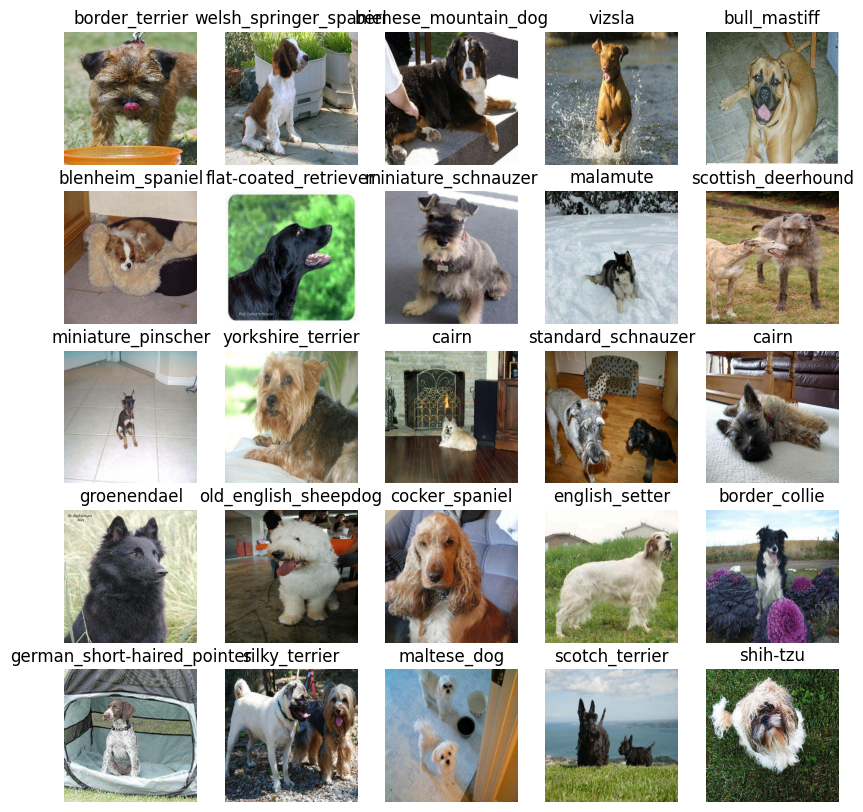

In [47]:
# To make computation efficient, a batch is a tightly wound collection of Tensor
# To view the data, need to undwind it with as_numpy_iterator() method on data batch
# Turns the data batch into something that can be iterated over. Passing an interabel
# (next) will return the new iterm in the iterator

train_images, train_labels = next(train_dataset.as_numpy_iterator())
show_25_images(train_images, train_labels)

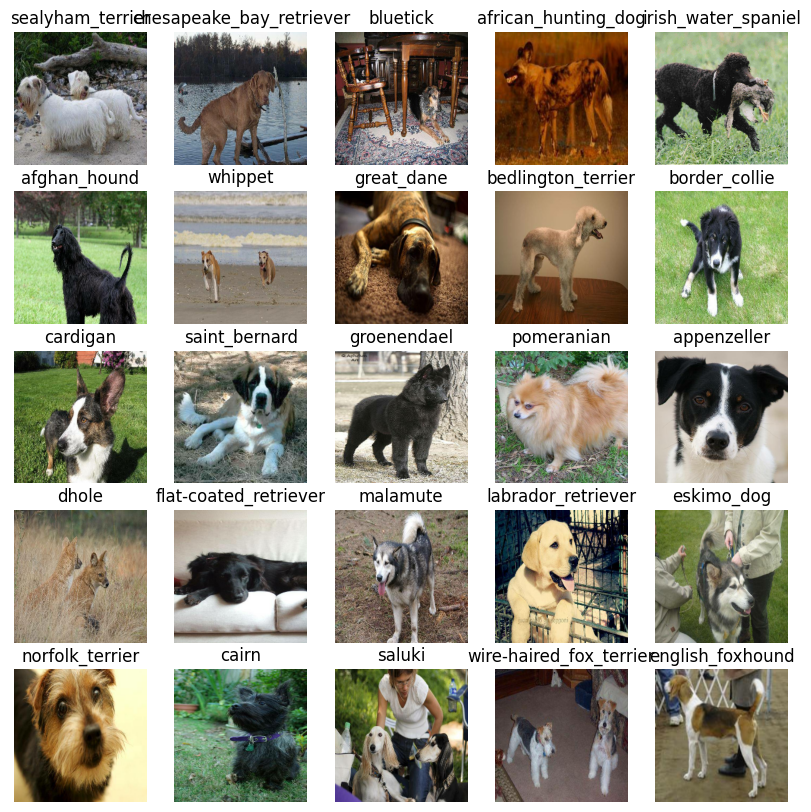

In [48]:
# Do the same for validation

val_images, val_labels = next(val_dataset.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Preparing Inputs and Outputs

##  Building a model

Before building a model, there are a few things need to define:
* The input shape (image shape in the form of Tensors) to our model
* The outshape( image labels, in the form of tensors) of our model
* URL of the model we want to use - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification

In [58]:
# Set up input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # Batch, Height, Width, Colour Channels

# Set up output shape of our model size
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4"

Create a function which:
* Takes the input shape, output shape and the model chosen as parameters
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (Shouls be evaluated and improved)
* Builds the model (Tell the model the input shape it will be getting)
* Returns the model

In [66]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building model with MobileNetV2 (Sequential)")
    model = tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape[1:]),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [67]:
model = create_model(INPUT_SHAPE)
model.summary()

Building model with MobileNetV2 (Sequential)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 2,377,592 (9.07 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
model = create_model()
model.summary()